# **Multi-Agent Chatbot Workflow with Conditional Reporting Agent**

### **Overview**
- **Orchestrator Agent:** Routes user queries, aggregates responses, and finalizes replies.  
- **SQL Agent:** Handles database-related queries and retrieves structured data.  
- **Enterprise Search Agent:** Handles document-related queries and retrieves unstructured text data.  
- **Reporting Agent:** Generates a structured report when explicitly requested by the user.  
- **Chat History:** Tracks all interactions, providing context across multiple queries.

## **1. State Definition**

Tracks the data moving between agents. Maintains context across the workflow.

In [1]:
class State:
    def __init__(self, user_query, chat_history=None, request_report=False):
        self.user_query = user_query  # Current query from the user
        self.route = None             # 'sql' or 'search'
        self.sql_result = None        # Result from SQL Agent
        self.search_result = None     # Result from Search Agent
        self.final_response = None    # Aggregated final response
        self.report = None            # Structured report from Reporting Agent
        self.request_report = request_report  # True if user requested a report
        self.chat_history = chat_history or []  # Stores previous interactions


    
    def __repr__(self):
        return (f"State(user_query={self.user_query}, route={self.route}, "
                f"sql_result={self.sql_result}, search_result={self.search_result}, "
                f"final_response={self.final_response}, report={self.report}, "
                f"request_report={self.request_report}, chat_history={self.chat_history})")
    
    def validate(self):
        if not isinstance(self.user_query, str):
            raise TypeError("user_query must be a string")
        if not isinstance(self.chat_history, list):
            raise TypeError("chat_history must be a list")
        if not isinstance(self.request_report, bool):
            raise TypeError("request_report must be a boolean")

## **2. Agents**

### **Orchestrator Agent**

- Handles routing based on query type.  
- Aggregates results after SQL or Search Agent completes their tasks.  
- Finalizes response or invokes the Reporting Agent if a report is requested.

In [2]:
from langgraph.graph import END

def orchestrator_agent(state: State):
    state.validate()
    print("[DEBUG] Entering orchestrator_agent")
    print("[DEBUG] State Type Before Processing:", type(state))
    
    if state.route is None:
        if "database" in state.user_query or "SQL" in state.user_query:
            state.route = "sql"
            return state
        else:
            state.route = "search"
            return state

    if state.route == "search":
        state.final_response = f"Search Result: {state.search_result}"
    elif state.route == "sql":
        state.final_response = f"Database Result: {state.sql_result}"
    
    state.chat_history.append({
        "user_query": state.user_query,
        "agent": state.route,
        "response": state.final_response
    })

    if state.request_report:
        state.route = "reporting"
        return state

    # Explicit Stop Condition
    if state.final_response is not None:
        print("[DEBUG] End of Workflow Reached - Returning END")
        return END  # Workflow ends here
    
    print("[DEBUG] Exiting orchestrator_agent with State:", state)
    return state


### **SQL Agent**

- Processes SQL-related queries.  
- Uses chat history for context if available.  
- Returns SQL query results to the Orchestrator Agent.

In [3]:
def sql_agent(state: State):
    state.validate()
    print("[DEBUG] Entering sql_agent")
    print("[DEBUG] State Type Before Processing in sql_agent:", type(state))
    
    context = "\n".join([
        f"User: {entry['user_query']}, Agent: {entry['agent']}, Response: {entry['response']}" 
        for entry in state.chat_history
    ])
    state.sql_result = f"SQL Query Result for '{state.user_query}' with context:\n{context}"
    
    print("[DEBUG] Exiting sql_agent with State:", state)
    return state


### **Enterprise Search Agent**

- Processes document-related queries.  
- Uses chat history for context if available.  
- Returns search results to the Orchestrator Agent.

In [4]:
def search_agent(state: State):
    state.validate()
    print("[DEBUG] Entering search_agent")
    print("[DEBUG] State Type Before Processing in search_agent:", type(state))
    
    context = "\n".join([
        f"User: {entry['user_query']}, Agent: {entry['agent']}, Response: {entry['response']}" 
        for entry in state.chat_history
    ])
    state.search_result = f"Search Result for '{state.user_query}' with context:\n{context}"
    
    print("[DEBUG] Exiting search_agent with State:", state)
    return state


### **Reporting Agent**

- Uses the final aggregated response from the Orchestrator Agent.  
- Creates a structured report from the aggregated data.

In [5]:
def reporting_agent(state: State):
    state.validate()
    print("[DEBUG] Entering reporting_agent")
    print("[DEBUG] State Type Before Processing in reporting_agent:", type(state))
    
    state.report = f"Aggregated Report:\n{state.final_response}\nGenerated using the final aggregated results."
    
    state.chat_history.append({
        "user_query": state.user_query,
        "agent": "reporting",
        "response": state.report
    })
    state.final_response = state.report
    
    print("[DEBUG] Exiting reporting_agent with State:", state)
    return state


## **3. Workflow Graph**

Defines how agents interact and specifies routing conditions.

In [6]:
from langgraph.graph import StateGraph, END

# Define the condition function
def orchestrator_condition(state: State):
    print("[DEBUG] Evaluating orchestrator_condition")
    print("[DEBUG] State Type Before Routing Decision:", type(state))
    
    if not isinstance(state, State):
        raise TypeError("[ERROR] State is not a valid State object in orchestrator_condition")

    if state.route in ["sql", "database"]:
        print("[DEBUG] Routing to sql_agent")
        return "to_sql_agent"
    if state.route == "search":
        print("[DEBUG] Routing to search_agent")
        return "to_search_agent"
    if state.request_report:
        print("[DEBUG] Routing to reporting_agent")
        return "to_reporting_agent"
    print("LKJDLKJL", state.final_response)
    # Workflow Stop Condition
    if state.final_response is not None:
        print("[DEBUG] Workflow Complete - Returning END")
        return END  # Stops the workflow

    raise ValueError("[ERROR] Invalid condition in orchestrator_condition")


graph = StateGraph(State)

# Add agents as nodes
graph.add_node("orchestrator_agent", orchestrator_agent)
graph.add_node("sql_agent", sql_agent)
graph.add_node("search_agent", search_agent)
graph.add_node("reporting_agent", reporting_agent)

# Define conditional transitions
graph.add_conditional_edges(
    source="orchestrator_agent",
    path=orchestrator_condition,
    path_map={
        "to_sql_agent": "sql_agent",
        "to_search_agent": "search_agent",
        "to_reporting_agent": "reporting_agent"
    }
)

# Define unconditional transitions
graph.add_edge("sql_agent", "orchestrator_agent")
graph.add_edge("search_agent", "orchestrator_agent")

# Set entry and finish points
graph.set_entry_point("orchestrator_agent")
graph.set_finish_point("orchestrator_agent")

# Compile the graph
app = graph.compile()



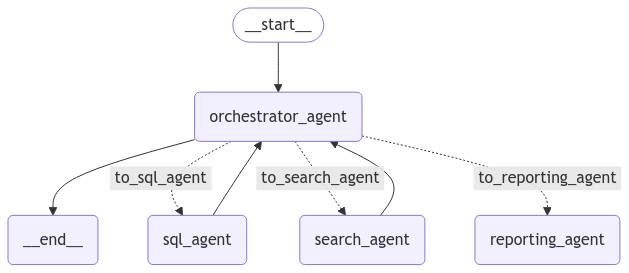

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# Run Workflow Scenarios

### Scenario 1: SQL → SQL → Search → Report

In [7]:
# Initial SQL Query
initial_state = State(user_query="Get customer details from the database.")
print("[DEBUG] Initial State Before Invoke:", initial_state)

state = app.invoke(initial_state)

if not isinstance(state, State):
    raise TypeError(f"[ERROR] app.invoke returned {type(state)} instead of 'State'. Value: {state}")

print("[DEBUG] Final State After Invoke:", state)
print("\nFinal Response:", state.final_response)

# Follow-Up SQL Query
state = app.invoke(State(
    user_query="What about their recent purchases?",
    request_report=state.request_report,
    chat_history=state.chat_history
))
print("\nFinal Response:", state.final_response)

# Follow-Up Search Query
state = app.invoke(State(
    user_query="Are there any documents related to these customers?",
    request_report=state.request_report,
    chat_history=state.chat_history
))
print("\nFinal Response:", state.final_response)

# Generate Report
state = app.invoke(State(
    user_query="Please generate a report for this.",
    request_report=True,
    chat_history=state.chat_history
))
print("\nFinal Report:", state.final_response)


[DEBUG] Initial State Before Invoke: State(user_query=Get customer details from the database., route=None, sql_result=None, search_result=None, final_response=None, report=None, request_report=False, chat_history=[])
[DEBUG] Entering orchestrator_agent
[DEBUG] State Type Before Processing: <class '__main__.State'>
[DEBUG] Evaluating orchestrator_condition
[DEBUG] State Type Before Routing Decision: <class '__main__.State'>
[DEBUG] Routing to sql_agent
[DEBUG] Entering sql_agent
[DEBUG] State Type Before Processing in sql_agent: <class '__main__.State'>
[DEBUG] Exiting sql_agent with State: State(user_query=Get customer details from the database., route=sql, sql_result=SQL Query Result for 'Get customer details from the database.' with context:
, search_result=None, final_response=None, report=None, request_report=False, chat_history=[])
[DEBUG] Entering orchestrator_agent
[DEBUG] State Type Before Processing: <class '__main__.State'>
[DEBUG] End of Workflow Reached - Returning END
[DEB

TypeError: [ERROR] State is not a valid State object in orchestrator_condition